## generate_data.py

In [94]:
import csv
import random
from datetime import datetime, timedelta
import json

# Generate data for 50 characters
NUM_ROWS = 1000

# Create the CSV file
OUTPUT_FILE = "troop_movements.csv"


def choose_a_side(home_world):
    """
    Randomly choose an empire or resistance side based on the likelihood 
    that someone from that world would join the rebel alliance.
    Args:
        home_world (dict): The home world data for the character.
    Returns:
        str: The empire or resistance side.
    """
    if home_world["rebel_likelihood"] > random.random():
        return "resistance"
    else:
        return "empire"


# Load home world data from JSON file
with open("home_worlds.json") as json_file:
    home_worlds = json.load(json_file)

# Generate data rows
data_rows = []
for i in range(1, NUM_ROWS + 1):
    # Generate random values for each column
    timestamp = datetime.now() - timedelta(seconds=i)
    unit_id = i
    unit_type = random.choice(
        ["stormtrooper", "tie_fighter", "at-st", "x-wing",
            "resistance_soldier", "at-at", "tie_silencer", "unknown"]
    )
    location_x = random.randint(1, 10)
    location_y = random.randint(1, 10)
    destination_x = random.randint(1, 10)
    destination_y = random.randint(1, 10)

    # Select a random home world from the available options
    home_world = random.choice(home_worlds)
    home_world_name = home_world["name"]
    empire_or_resistance = choose_a_side(home_world)

    # Create the data row
    data_row = [
        timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        unit_id,
        unit_type,
        empire_or_resistance,
        location_x,
        location_y,
        destination_x,
        destination_y,
        home_world_name,
    ]

    # Add the data row to the list
    data_rows.append(data_row)

# Write the data to the CSV file
with open(OUTPUT_FILE, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(
        ["timestamp", "unit_id", "unit_type", "empire_or_resistance", "location_x", "location_y", "destination_x",
         "destination_y", "homeworld"]
    )
    writer.writerows(data_rows)

print("Data generation complete.")


Data generation complete.


### Display troop_movements.csv as DataFrame

In [95]:
import pandas as pd
df = pd.read_csv("troop_movements.csv")
print(df)

               timestamp  unit_id           unit_type empire_or_resistance  \
0    2024-02-07 11:27:08        1             unknown               empire   
1    2024-02-07 11:27:07        2             unknown           resistance   
2    2024-02-07 11:27:06        3        stormtrooper               empire   
3    2024-02-07 11:27:05        4         tie_fighter           resistance   
4    2024-02-07 11:27:04        5         tie_fighter           resistance   
..                   ...      ...                 ...                  ...   
995  2024-02-07 11:10:33      996               at-st               empire   
996  2024-02-07 11:10:32      997               at-at           resistance   
997  2024-02-07 11:10:31      998              x-wing           resistance   
998  2024-02-07 11:10:30      999              x-wing           resistance   
999  2024-02-07 11:10:29     1000  resistance_soldier           resistance   

     location_x  location_y  destination_x  destination_y    ho

### Part 2: Build a prediction model

In [96]:
# Create grouped data showing counts of empire vs resistance.
er = df.groupby("empire_or_resistance").size().reset_index(name="count")
print(er.head())

  empire_or_resistance  count
0               empire    524
1           resistance    476


In [97]:
# Create grouped data showing counts of characters by homeworld
homeworld_counts = df.groupby("homeworld").size().reset_index(name="count")
print(homeworld_counts.head())


     homeworld  count
0     Alderaan     19
1  Aleen Minor     26
2   Bestine IV     24
3        Cerea     31
4     Champala     23


In [98]:
# Created grouped data showing counts of characters by unit_type
unit_type_counts = df.groupby("unit_type").size().reset_index(name="count")
print(unit_type_counts.head())


            unit_type  count
0               at-at    122
1               at-st    122
2  resistance_soldier    143
3        stormtrooper    131
4         tie_fighter    106


In [99]:
# Engineer a new feature called is_resistance with a True or False value based on empire_or_resiatance
df['is_resistance'] = df["empire_or_resistance"].map(lambda x: x == "resistance")
df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2024-02-07 11:27:08,1,unknown,empire,7,8,8,5,Muunilinst,False
1,2024-02-07 11:27:07,2,unknown,resistance,6,3,5,4,Eriadu,True
2,2024-02-07 11:27:06,3,stormtrooper,empire,1,9,4,8,Skako,False
3,2024-02-07 11:27:05,4,tie_fighter,resistance,7,10,4,5,Sullust,True
4,2024-02-07 11:27:04,5,tie_fighter,resistance,6,3,7,1,Umbara,True


<Axes: xlabel='empire_or_resistance', ylabel='count'>

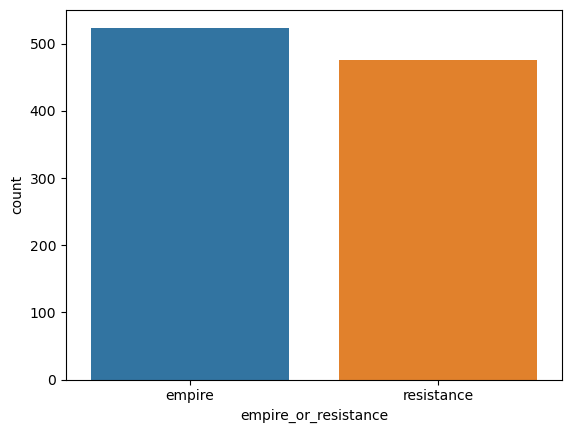

In [100]:
# Create a bar plot using Seaborn showing Empire vs Resistance distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x = 'empire_or_resistance',y='count',data = er)

In [101]:
# Create a prediction model using sklearn.tree.DecisionTreeClassifier that predicts if a character is joining either the Empire or the Resistance based on their homeworld and unit_type.
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [102]:
features = ["homeworld","unit_type"]
# Convert categorical features to numeric using pd.get_dummies. 
df1 = df.copy()
X_encoded = pd.get_dummies(df[features])
y_encoded = pd.get_dummies(df['empire_or_resistance'])

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1)

model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(y_pred)

[[1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]

                         Feature  Importance
0             homeworld_Alderaan    0.021677
1          homeworld_Aleen Minor    0.004946
2           homeworld_Bestine IV    0.018416
3                homeworld_Cerea    0.011311
4             homeworld_Champala    0.003766
5            homeworld_Chandrila    0.007012
6         homeworld_Concord Dawn    0.015404
7             homeworld_Corellia    0.039143
8              homeworld_Dagobah    0.031462
9             homeworld_Dathomir    0.010669
10               homeworld_Dorin    0.006387
11              homeworld_Eriadu    0.030090
12         homeworld_Glee Anselm    0.013717
13          homeworld_Haruun Kal    0.005034
14             homeworld_Iktotch    0.006782
15            homeworld_Iridonia    0.005094
16               homeworld_Kalee    0.013467
17            homeworld_Kashyyyk    0.009838
18           homeworld_Malastare    0.006628
19              homeworld_Mirial    0.001893
20            homeworld_Mon Cala    0.010214
21        

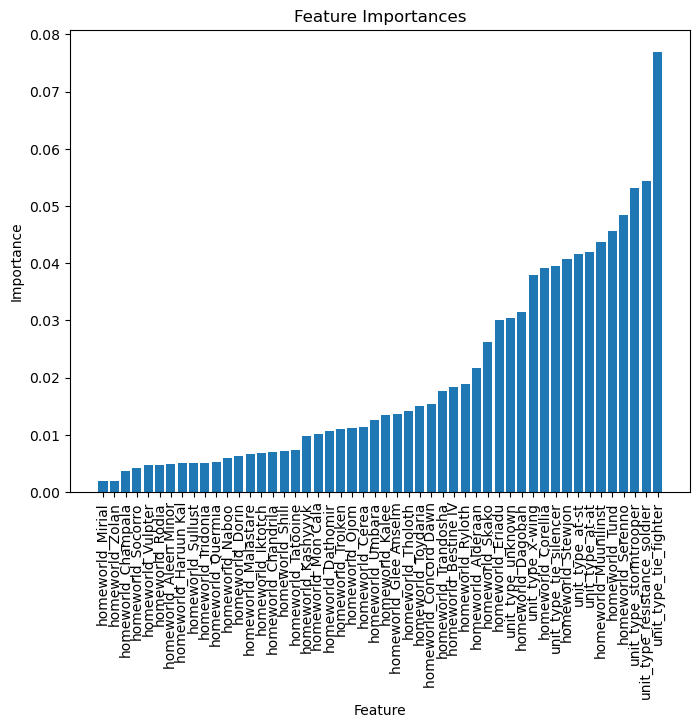

In [104]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
print(feature_importances)
feature_importances = feature_importances.sort_values('Importance', ascending=True)

# Create a bar plot that shows feature importance.
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [105]:
# Save to model as a pickle file named trained_model.pkl
import pickle
filename = "trained_model.pkl"
with open(filename, 'wb') as file:
      pickle.dump(model, file)

### Part 3: Use the trained model with “real” data

Load data from troop_movements10m.csv (see Guided Project zip for file). This file contains 10 million records to be predicted. 
This data must be cleaned up a bit before it can be used:

⦁	Some unit_type records have a value of invalid_unit. Replace that with unknown.

⦁	Some location_x and location_Y values are missing. Use the ffill method to fill.

⦁	Save the clean data into a Parquet file named troop_movements10m.parquet.

⦁	You need to install pyarrow and fastparquet to support saving to a Parquet file.

pip install pyarrow

pip install fastparquet

Load the pickled model and load the data from the Parquet file into a data frame. Run the data through the model.


In [106]:
df_trained = pd.read_csv('troop_movements.csv')

In [107]:
%pip install pyarrow
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [108]:
df_trained.unit_type.replace("invalid_unit","unknown")

0                 unknown
1                 unknown
2            stormtrooper
3             tie_fighter
4             tie_fighter
              ...        
995                 at-st
996                 at-at
997                x-wing
998                x-wing
999    resistance_soldier
Name: unit_type, Length: 1000, dtype: object

In [109]:
df_trained.location_x.ffill()
df_trained.location_y.ffill()


0       8
1       3
2       9
3      10
4       3
       ..
995     1
996     1
997     5
998     6
999     7
Name: location_y, Length: 1000, dtype: int64

In [110]:
pquet = df_trained.to_parquet("clean_troopers.parquet")

In [111]:
with open("trained_model.pkl",'rb') as f: 
    model2 = pickle.load(f)

parquet_db = pd.read_parquet('clean_troopers.parquet', engine = 'pyarrow')

In [112]:
features = ["homeworld","unit_type"]
# Convert categorical features to numeric using pd.get_dummies. 
X_encoded = pd.get_dummies(parquet_db[features])
y_encoded = pd.get_dummies(parquet_db['empire_or_resistance'])

print(X_encoded)
print(y_encoded)

     homeworld_Alderaan  homeworld_Aleen Minor  homeworld_Bestine IV  \
0                     0                      0                     0   
1                     0                      0                     0   
2                     0                      0                     0   
3                     0                      0                     0   
4                     0                      0                     0   
..                  ...                    ...                   ...   
995                   0                      0                     0   
996                   0                      0                     0   
997                   0                      1                     0   
998                   0                      1                     0   
999                   0                      0                     0   

     homeworld_Cerea  homeworld_Champala  homeworld_Chandrila  \
0                  0                   0                    0   
1    

In [113]:
ypred = model2.predict(X_encoded)


                         Feature  Importance
0             homeworld_Alderaan    0.021677
1          homeworld_Aleen Minor    0.004946
2           homeworld_Bestine IV    0.018416
3                homeworld_Cerea    0.011311
4             homeworld_Champala    0.003766
5            homeworld_Chandrila    0.007012
6         homeworld_Concord Dawn    0.015404
7             homeworld_Corellia    0.039143
8              homeworld_Dagobah    0.031462
9             homeworld_Dathomir    0.010669
10               homeworld_Dorin    0.006387
11              homeworld_Eriadu    0.030090
12         homeworld_Glee Anselm    0.013717
13          homeworld_Haruun Kal    0.005034
14             homeworld_Iktotch    0.006782
15            homeworld_Iridonia    0.005094
16               homeworld_Kalee    0.013467
17            homeworld_Kashyyyk    0.009838
18           homeworld_Malastare    0.006628
19              homeworld_Mirial    0.001893
20            homeworld_Mon Cala    0.010214
21        

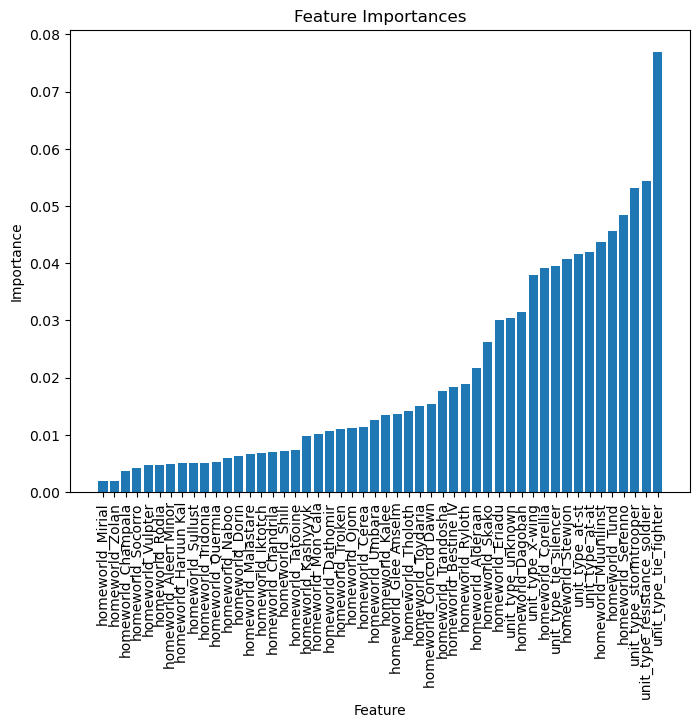

In [114]:
importances = model2.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
print(feature_importances)
feature_importances = feature_importances.sort_values('Importance', ascending=True)

# Create a bar plot that shows feature importance.
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()